In [1]:
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt

# CIFAR-10 데이터 로드
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# CIFAR-10 클래스 이름
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']


In [2]:
#모델 로드
from tensorflow.keras.layers import TFSMLayer
import tensorflow as tf
import numpy as np

# SavedModel 경로
saved_model_path = "saved_model/1"

# TFSMLayer로 모델 로드
model = TFSMLayer(saved_model_path, call_endpoint='serving_default')

# CIFAR-10 데이터 로드 및 정규화
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 데이터 타입 변환 및 정규화
x_test = x_test.astype("float32") / 255.0

# 테스트 데이터 예측
predictions = model(x_test)
print("Predictions:", predictions)


AttributeError: module 'ml_dtypes' has no attribute 'float8_e3m4'
Predictions: {'output_0': <tf.Tensor: shape=(10000, 10), dtype=float32, numpy=
array([[1.67760793e-02, 2.25583310e-04, 1.39172748e-02, ...,
        2.05968716e-03, 1.41739473e-01, 5.07593155e-03],
       [2.42158659e-02, 4.54587519e-01, 1.70806914e-06, ...,
        5.72899985e-08, 5.18670797e-01, 2.52135657e-03],
       [5.19017339e-01, 7.27866217e-02, 9.30869766e-03, ...,
        3.74218286e-03, 2.83091098e-01, 1.01302378e-01],
       ...,
       [2.24907068e-04, 1.22234205e-05, 2.00120747e-01, ...,
        3.34983729e-02, 9.58154051e-05, 4.49991756e-04],
       [4.94978987e-02, 2.01404840e-01, 1.27283949e-02, ...,
        6.05678605e-03, 1.17189845e-03, 2.12535169e-03],
       [5.05116695e-05, 6.09907947e-05, 2.29541934e-03, ...,
        9.16872740e-01, 1.80720726e-05, 3.48947302e-04]], dtype=float32)>}


In [3]:
# 모델 예측 수행
predictions = model(x_test)

# 딕셔너리에서 출력 텐서 추출
predictions_tensor = predictions['output_0']

# 예측된 레이블 (가장 높은 확률의 인덱스)
predicted_labels = tf.argmax(predictions_tensor, axis=1).numpy()

# 실제 레이블과 비교
incorrect_indices = np.where(predicted_labels != y_test.flatten())[0]

# 잘못된 예측 중 첫 22개 선택
incorrect_indices = incorrect_indices[:22]
print(f"Incorrect indices: {incorrect_indices}")



Incorrect indices: [ 2  4  7 10 15 22 24 25 27 30 31 33 35 37 40 46 49 51 52 57 58 59]


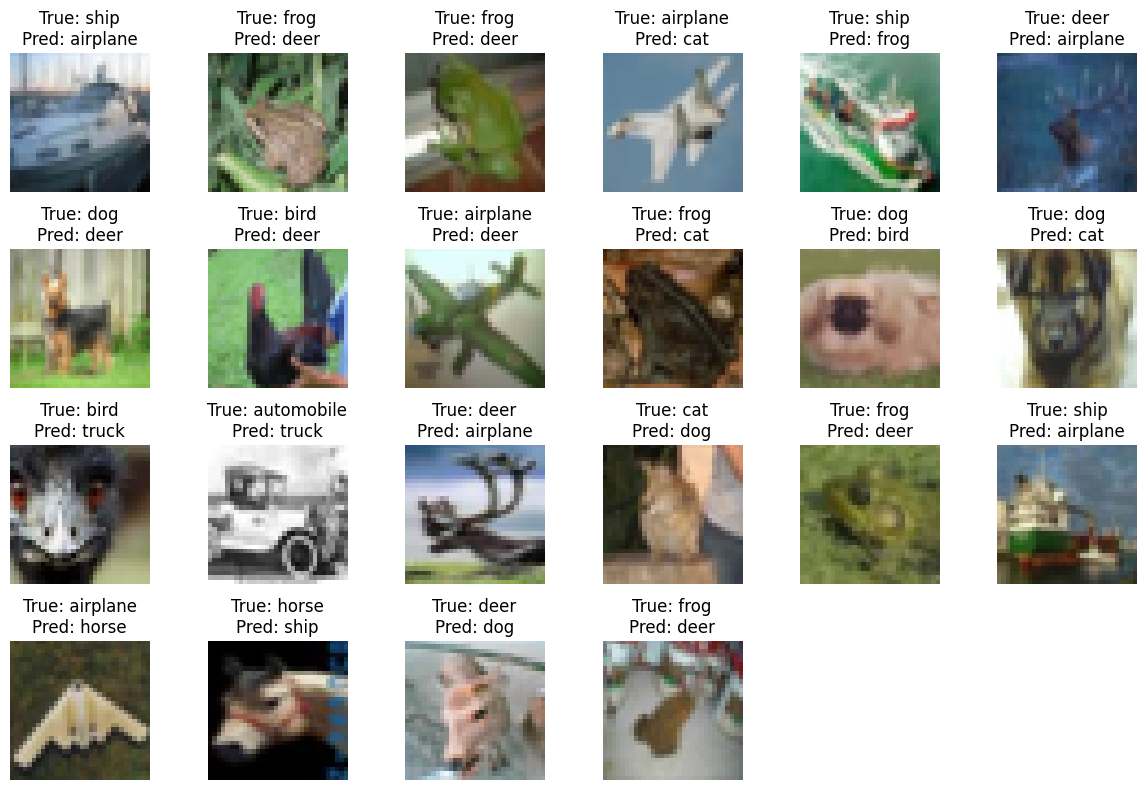

In [4]:
# 잘못된 예측 시각화
plt.figure(figsize=(12, 8))
for i, idx in enumerate(incorrect_indices):
    plt.subplot(4, 6, i + 1)
    plt.imshow(x_test[idx])
    plt.title(f"True: {class_names[y_test[idx][0]]}\nPred: {class_names[predicted_labels[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [5]:
# 잘못된 예측 인덱스와 수정할 올바른 레이블 정의
corrected_labels = {
    2: class_names.index('airplane'),
    4: class_names.index('frog'),
    7: class_names.index('frog'),
    10: class_names.index('airplane'),
    15: class_names.index('ship'),
    22: class_names.index('deer'),
    24: class_names.index('dog'),
    25: class_names.index('bird'),
    27: class_names.index('airplane'),
    30: class_names.index('frog'),
    31: class_names.index('dog'),
    33: class_names.index('dog'),
    35: class_names.index('bird'),
    37: class_names.index('automobile'),
    40: class_names.index('deer'),
    46: class_names.index('cat'),
    49: class_names.index('frog'),
    51: class_names.index('ship'),
    52: class_names.index('airplane'),
    57: class_names.index('horse'),
    58: class_names.index('deer'),
    59: class_names.index('frog')
}

In [6]:
# 기존 레이블 복사
y_test_fixed = y_test.copy()

# 잘못된 레이블 수정
for idx, correct_label in corrected_labels.items():
    y_test_fixed[idx] = correct_label


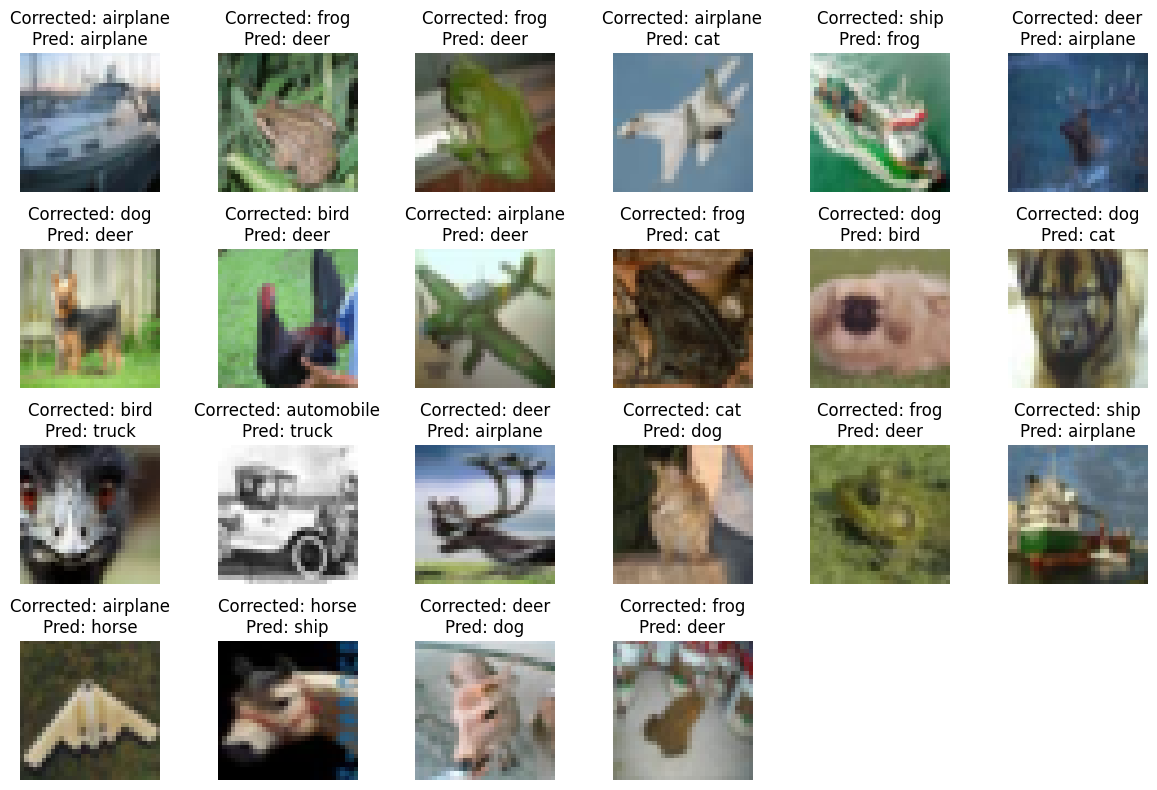

In [7]:
# 수정된 결과 시각화
plt.figure(figsize=(12, 8))
for i, idx in enumerate(corrected_labels.keys()):
    plt.subplot(4, 6, i + 1)
    plt.imshow(x_test[idx])
    plt.title(f"Corrected: {class_names[y_test_fixed[idx][0]]}\nPred: {class_names[predicted_labels[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from tensorflow.keras.datasets import cifar10

# 데이터 로드 및 전처리
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# One-hot encoding
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# 모델 빌드 함수 (튜닝 대상)
def build_model(hp):
    model = keras.Sequential()
    model.add(
        layers.Conv2D(
            filters=hp.Int("conv1_filters", min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice("conv1_kernel", values=[3, 5]),
            activation="relu",
            input_shape=(32, 32, 3),
        )
    )
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(
        layers.Conv2D(
            filters=hp.Int("conv2_filters", min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice("conv2_kernel", values=[3, 5]),
            activation="relu",
        )
    )
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(
        layers.Dense(
            units=hp.Int("dense_units", min_value=64, max_value=256, step=64),
            activation="relu",
        )
    )
    model.add(layers.Dense(10, activation="softmax"))

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
        ),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

# KerasTuner를 사용한 하이퍼파라미터 튜닝
tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=10,
    factor=3,
    directory="my_dir",
    project_name="cifar10_tuning",
)

# 콜백 설정
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

# 하이퍼파라미터 튜닝
tuner.search(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# 최적의 하이퍼파라미터 가져오기
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# 최적 하이퍼파라미터 출력
print(f"""
The optimal number of filters for the first Conv2D layer is {best_hps.get('conv1_filters')} with a kernel size of {best_hps.get('conv1_kernel')}.
The optimal number of filters for the second Conv2D layer is {best_hps.get('conv2_filters')} with a kernel size of {best_hps.get('conv2_kernel')}.
The optimal number of units in the dense layer is {best_hps.get('dense_units')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

# 최적화된 하이퍼파라미터로 모델 학습
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=50, validation_split=0.2)

# 테스트 데이터 평가
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc}")

# 모델 저장
model.save("optimized_cifar10_model.h5")


Trial 30 Complete [00h 06m 27s]
val_accuracy: 0.6658999919891357

Best val_accuracy So Far: 0.6977999806404114
Total elapsed time: 1d 17h 28m 15s

The optimal number of filters for the first Conv2D layer is 128 with a kernel size of 5.
The optimal number of filters for the second Conv2D layer is 128 with a kernel size of 5.
The optimal number of units in the dense layer is 256.
The optimal learning rate for the optimizer is 0.0001.

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - accuracy: 0.3140 - loss: 1.8560 - val_accuracy: 0.5044 - val_loss: 1.3954
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 72s 58ms/step - accuracy: 0.5193 - loss: 1.3418 - val_accuracy: 0.5642 - val_loss: 1.2375
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 68s 55ms/step - accuracy: 0.5946 - loss: 1.1680 - val_accuracy: 0.6072 - val_loss: 1.1521
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 72s 58ms/step - accuracy: 0.6207 - loss: 1.0859 - val_accuracy: 0.6253 - val_loss: 1.0851
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━

Test Accuracy: 0.6990000009536743
